# Método de momentos

In [26]:
import matplotlib.pyplot as plt
import pylab as py
import numpy as np
from numpy import sqrt, cos, sin, pi
import sys

# py.rcParams['mathtext.fontset'] = 'stix'
# py.rcParams.update({'font.size': 14})


np.seterr(divide='ignore')  # Elimina advertencia al dividir por cero.
# %precision %.3f

!pip install --index-url https://test.pypi.org/simple/ --no-deps --upgrade frautnEM
from frautnEM.puntuales import plotEf, equipotencialesPuntuales

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  !pip --quiet install ipympl
  from google.colab import output
  output.enable_custom_widget_manager()

# Figuras interactivas.
# Comentar si se quiere mantener las figuras luego de cerrar el cuaderno.
# %matplotlib widget

Looking in indexes: https://test.pypi.org/simple/


## Cilindro conductor

Se sigue el método descripto en el capítulo 2 del libro _The method of moments in electromagnetics_, W. C. Gibson.

<div><image src="img/c2_cilindro.png"  width="400"></div>

<div><image src="img/c2_cilindro_discretizado.png"  width="500"></div>


La ecuación 2.12 no es correcta, debería ser:

$$
Z_{mn} = \int_{(n-1)\Delta}^{n\Delta} \frac{1}{\sqrt{(x_m - x')^2+a^2}} dx' \, .
$$

La ecuación 2.14 no es el resultado correcto, sino el siguiente:

$$
Z_{mn} = \log \left ( \frac{\sqrt{a^2+(x_a-x_m)^2}-(x_a-x_m)}{\sqrt{a^2+(x_b-x_m)^2}-(x_b-x_m)} \right ) \, ,
$$

siendo $x_a = (n-1)\Delta$ y $x_b =n\Delta$. 

In [27]:
def Zmn(row, m, a, delta):
    xm = delta/2 + (m-1) * delta  # El centro del segmento.
    xa = (row - 1) * delta
    xb = row * delta
    num = np.sqrt(a * a + (xa - xm) * (xa - xm)) - (xa - xm)
    den = np.sqrt(a * a + (xb - xm) * (xb - xm)) - (xb - xm)
    
    return np.log(num/den)

In [28]:
# Potencial:
b = 1
# Largo:
L = 1

N = 100
a = 0.01
delta = L/N

row = np.array(np.arange(1,N+1))
Z = np.array([]).reshape(0,N)
for m in np.arange(1,N+1):
    Z = np.concatenate([Z, Zmn(row, m, a, delta).reshape(1,N)], axis=0)

B = np.ones(N)*b
q = np.linalg.solve(Z, B)

# Check that the solution is correct:
np.allclose(np.dot(Z, q), B)

True

In [29]:
# El resultado es kQ, entonces:
q = q / 9E9

# Se arma la lista de cargas del hilo:
x = (-L/2 + delta * (-0.5 + row)).reshape(1,N)
y = np.zeros(N).reshape(1,N)
z = np.zeros(N).reshape(1,N)
Q = np.concatenate([q.reshape(1,N),x,y,z], axis=0)
Q = np.transpose(Q)


In [30]:
Nx = 200
Ny = 200
x = np.linspace(-1,1,Nx)        # x variables in 1D
y = np.linspace(-1,1,Ny)        # y variable in 1D
X,Y = np.meshgrid(x,y)          # 2D meshgrid


In [31]:
def Efield2D(x, y, Q):
    """Calcula las componentes del campo eléctrico en N/C.
    Ingresar valores de x,y,z en metros y q en coulomb.
    Q es una lista de la forma:
    Q = [
        [q1,x1,y1],
        [q2,x2,y2],
        ...
        [qN,xN,yN]
    ]
    """
    k = 9E9   #Constante de Coulomb en las unidades correspondientes.

    Ei,Ej= 0,0
    for qi in Q:
        r = ((x - qi[1])**2 + (y - qi[2])**2)**(3/2)
        Ei = Ei + k * qi[0] * (x - qi[1]) / r
        Ej = Ej + k * qi[0] * (y - qi[2]) / r

    return Ei, Ej

def region_conductor(x,y):
    regionx = np.piecewise(X, [(X > -0.5) & (X < 0.5), ], [0, 1])
    regiony = np.piecewise(Y, [(Y > -0.01) & (Y < 0.01), ], [0, 1])
    region = regionx + regiony
    region = np.piecewise(region, [region > 0], [1, 0])

    return region

# Defining custom plotting functions
def my_contourf(x,y,F,ttl,clrmp = 'inferno'):
    cnt = py.contourf(x,y,F,41,cmap = clrmp)
    
    # Antialiasing block for exporting figure to pdf later
    for c in cnt.collections:
        c.set_edgecolor("face")
    
    cbar = py.colorbar()
    # py.xlabel(r'$x$',fontsize=26); py.ylabel(r'$y$',fontsize=26); 
    py.xlabel(r'$x$'); py.ylabel(r'$y$'); 
    # py.title(ttl)
    # cbar.set_label(ttl,fontsize=26)
    cbar.set_label(ttl)
    # py.xlim([x[0],x[-1]])
    # py.ylim([y[0],y[-1]])
    return 0


/tmp/ipykernel_14945/1614861169.py:35: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in cnt.collections:


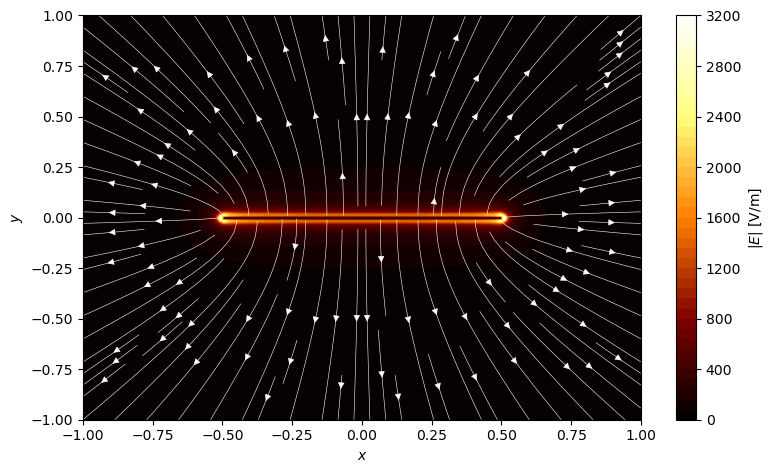

In [32]:
region = region_conductor(X,Y)
Ei, Ej = Efield2D(X,Y,Q)

Ei = Ei * region 
Ej = Ej * region 

Emod = np.sqrt(Ei**2 + Ej**2)

# py.figure(figsize = (12,7))
py.figure(figsize = (9,5.25))
my_contourf(X,Y,Emod,r'$|E|$ [V/m]','afmhot')
py.streamplot(X,Y,Ei,Ej,color = 'w',density = 1.2, linewidth = 0.4)


In [33]:
q

array([5.19670885e-11, 5.73100832e-12, 2.04603108e-11, 1.41084743e-11,
       1.53773470e-11, 1.43048522e-11, 1.41735016e-11, 1.38219192e-11,
       1.36144861e-11, 1.34095673e-11, 1.32430321e-11, 1.30943303e-11,
       1.29643805e-11, 1.28483977e-11, 1.27446076e-11, 1.26509810e-11,
       1.25661307e-11, 1.24888650e-11, 1.24182387e-11, 1.23534637e-11,
       1.22938868e-11, 1.22389582e-11, 1.21882124e-11, 1.21412522e-11,
       1.20977366e-11, 1.20573710e-11, 1.20198995e-11, 1.19850991e-11,
       1.19527742e-11, 1.19227530e-11, 1.18948838e-11, 1.18690326e-11,
       1.18450806e-11, 1.18229223e-11, 1.18024637e-11, 1.17836216e-11,
       1.17663216e-11, 1.17504975e-11, 1.17360909e-11, 1.17230497e-11,
       1.17113279e-11, 1.17008853e-11, 1.16916865e-11, 1.16837012e-11,
       1.16769032e-11, 1.16712707e-11, 1.16667858e-11, 1.16634343e-11,
       1.16612058e-11, 1.16600932e-11, 1.16600932e-11, 1.16612058e-11,
       1.16634343e-11, 1.16667858e-11, 1.16712707e-11, 1.16769032e-11,
      

In [34]:
type(q)

numpy.ndarray

In [35]:
np.sum(q)

1.3200403675967931e-09